In [2]:
from itertools import product

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay


In [3]:

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=0.1, kernel="rbf", probability=True)
eclf = VotingClassifier(
    estimators=[("dt", clf1), ("knn", clf2), ("svc", clf3)],
    voting="soft",
    weights=[2, 1, 2],
)


In [4]:

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)



VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=4)),
                             ('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('svc', SVC(gamma=0.1, probability=True))],
                 voting='soft', weights=[2, 1, 2])

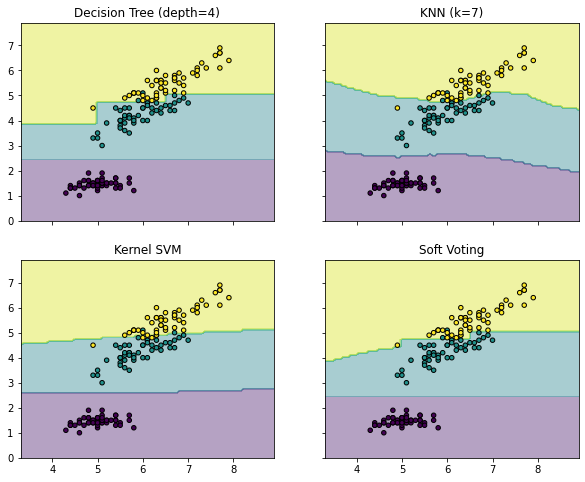

In [5]:
# Plotting decision regions
f, axarr = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 8))
for idx, clf, tt in zip(
    product([0, 1], [0, 1]),
    [clf1, clf2, clf3, eclf],
    ["Decision Tree (depth=4)", "KNN (k=7)", "Kernel SVM", "Soft Voting"],
):
    DecisionBoundaryDisplay.from_estimator(
        clf, X, alpha=0.4, ax=axarr[idx[0], idx[1]], response_method="predict"
    )
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brunosette","key":"92739e7643e0e09262cd6511b4b0c752"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [2]:
!kaggle competitions download -c titanic

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 8.59MB/s]


In [7]:
!unzip titanic.zip -d data/titanic/

Archive:  titanic.zip
  inflating: data/titanic/gender_submission.csv  
  inflating: data/titanic/test.csv   
  inflating: data/titanic/train.csv  


In [8]:
training_data = pd.read_csv("data/titanic/train.csv")
testing_data = pd.read_csv("data/titanic/test.csv")

def get_nulls(training, testing):
    print("Training Data:")
    print(pd.isnull(training).sum())
    print("Testing Data:")
    print(pd.isnull(testing).sum())

get_nulls(training_data, testing_data)

Training Data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [9]:
# Drop the cabin column, as there are too many missing values
# Drop the ticket numbers too, as there are too many categories
# Drop names as they won't really help predict survivors

training_data.drop(labels=['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)
testing_data.drop(labels=['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

# Taking the mean/average value would be impacted by the skew
# so we should use the median value to impute missing values

training_data["Age"].fillna(training_data["Age"].median(), inplace=True)
testing_data["Age"].fillna(testing_data["Age"].median(), inplace=True)
training_data["Embarked"].fillna("S", inplace=True)
testing_data["Fare"].fillna(testing_data["Fare"].median(), inplace=True)

get_nulls(training_data, testing_data)

Training Data:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Testing Data:
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


In [10]:
encoder_1 = LabelEncoder()
# Fit the encoder on the data
encoder_1.fit(training_data["Sex"])

# Transform and replace training data
training_sex_encoded = encoder_1.transform(training_data["Sex"])
training_data["Sex"] = training_sex_encoded
test_sex_encoded = encoder_1.transform(testing_data["Sex"])
testing_data["Sex"] = test_sex_encoded

encoder_2 = LabelEncoder()
encoder_2.fit(training_data["Embarked"])

training_embarked_encoded = encoder_2.transform(training_data["Embarked"])
training_data["Embarked"] = training_embarked_encoded
testing_embarked_encoded = encoder_2.transform(testing_data["Embarked"])
testing_data["Embarked"] = testing_embarked_encoded

# Any value we want to reshape needs be turned into array first
ages_train = np.array(training_data["Age"]).reshape(-1, 1)
fares_train = np.array(training_data["Fare"]).reshape(-1, 1)
ages_test = np.array(testing_data["Age"]).reshape(-1, 1)
fares_test = np.array(testing_data["Fare"]).reshape(-1, 1)

# Scaler takes arrays
scaler = StandardScaler()

training_data["Age"] = scaler.fit_transform(ages_train)
training_data["Fare"] = scaler.fit_transform(fares_train)
testing_data["Age"] = scaler.fit_transform(ages_test)
testing_data["Fare"] = scaler.fit_transform(fares_test)

In [11]:
# Now to select our training/testing data
X_features = training_data.drop(labels=['PassengerId', 'Survived'], axis=1)
y_labels = training_data['Survived']

print(X_features.head(5))

# Make the train/test data from validation

X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.1, random_state=27)

   Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
0       3    1 -0.565736      1      0 -0.502445         2
1       1    0  0.663861      1      0  0.786845         0
2       3    0 -0.258337      0      0 -0.488854         2
3       1    0  0.433312      1      0  0.420730         2
4       3    1  0.433312      0      0 -0.486337         2


In [12]:
LogReg_clf = LogisticRegression()
DTree_clf = DecisionTreeClassifier()
SVC_clf = SVC()

LogReg_clf.fit(X_train, y_train)
DTree_clf.fit(X_train, y_train)
SVC_clf.fit(X_train, y_train)

LogReg_pred = LogReg_clf.predict(X_val)
DTree_pred = DTree_clf.predict(X_val)
SVC_pred = SVC_clf.predict(X_val)

averaged_preds = (LogReg_pred + DTree_pred + SVC_pred)//3
acc = accuracy_score(y_val, averaged_preds)
print(acc)

0.8444444444444444


In [13]:
voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf)], voting='hard')
voting_clf.fit(X_train, y_train)
preds = voting_clf.predict(X_val)
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

Accuracy is: 0.9
Log Loss is: 3.4539042927387427
F1 Score is: 0.8656716417910447
